In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn import linear_model

# Motion Data loading

In [3]:
motion_path = "motion.tsv"
df_motion = pd.read_csv(motion_path, sep="\t", header=None, index_col=0)

In [4]:
df_motion.head()

,1,2,3,4,5
0,,,,,
2017-05-23T05:45:16.325908+00:00,0,0,0,0,0
2017-05-23T05:45:33.516809+00:00,1,0,0,0,0
2017-05-23T05:50:12.286779+00:00,0,0,0,0,0
2017-05-23T05:50:18.664725+00:00,1,0,0,0,0
2017-05-23T05:59:42.986589+00:00,0,0,0,0,0


# Motion Data formatting

In [5]:
df_motion.index = pd.to_datetime(df_motion.index, infer_datetime_format=True)

In [6]:
df_motion.head()

,1,2,3,4,5
0,,,,,
2017-05-23 05:45:16.325908,0,0,0,0,0
2017-05-23 05:45:33.516809,1,0,0,0,0
2017-05-23 05:50:12.286779,0,0,0,0,0
2017-05-23 05:50:18.664725,1,0,0,0,0
2017-05-23 05:59:42.986589,0,0,0,0,0


In [7]:
df_motion

,1,2,3,4,5
0,,,,,
2017-05-23 05:45:16.325908,0,0,0,0,0
2017-05-23 05:45:33.516809,1,0,0,0,0
2017-05-23 05:50:12.286779,0,0,0,0,0
2017-05-23 05:50:18.664725,1,0,0,0,0
2017-05-23 05:59:42.986589,0,0,0,0,0
2017-05-23 05:59:51.586922,1,0,0,0,0
2017-05-23 06:00:22.490134,0,0,0,0,0
2017-05-23 06:00:49.889853,1,0,0,0,0
2017-05-23 06:00:53.760098,0,0,0,0,0


In [8]:
# TODO: lot of unnecessary information, see if possible to reduce amount of data. For example by adding consecutive rows..
df_walking = df_motion[2]

## time span

In [9]:
analysis_time_span = pd.to_timedelta(48, unit="h")
first_date = df_walking.index[0] + analysis_time_span

In [10]:
first_date

Timestamp('2017-05-25 05:45:16.325908')

In [11]:
time_serie_frequency = pd.to_timedelta(15, unit="m")
number_of_values = int((df_walking.index[-1] - first_date) / time_serie_frequency)
last_date = first_date + number_of_values * time_serie_frequency
print(last_date)

2017-06-02 23:45:16.325908


# First task

In [12]:
walking_time = np.zeros(number_of_values)

In [13]:
# TODO: iterating over a dataframe's rows is not very efficient. Think of a better way.
def time_in_activity_between(s, start, stop):
    """Compute the time spent in a certain activity between start and stop time.
    
    This function aggregates the time spent in a certain activity given by a pd
    Series between a start and stop time. It will consider the activity happening
    before the time span to see if we begin by walking.
    
    Arguments:
        - s (pd.Series): the series containing the activity state with the time
        in index.
        - start (pd.TimeStamp): the beginning of the period of interest.
        - stop (pd.TimeStamp): the end of the period of interest.
        
    Returns:
        - float: the time spent in activity expressed in minutes.
    """
    res = 0
    time_prev = 0
    state_prev = 0
    one_minute = pd.offsets.Minute(1)
    s_interest = s[start:stop]
    if len(s_interest) > 0:
        # Let's look at what was happening before
        first_time_interest = s_interest.index[0]
        iloc_time = s.index.get_loc(first_time_interest)
        if iloc_time > 0:
            if s[iloc_time - 1] == 1:
                time_prev = start
                state_prev = 1
        # Now let's iterate through the rows
        for time, state in s_interest.iteritems():
            if state_prev == 1 and state == 0:
                res += (time - time_prev) / one_minute
            if state == 0:
                time_prev = time
                state_prev = 0
            if state == 1 and state_prev == 0:
                time_prev = time
                state_prev = 1
        # Let's account for the last activity
        if state_prev == 1:
            res += (stop - time_prev) / one_minute
    else:
        # nothing is changing in that time span
        last_state_index = s[s.index<start].index[-1]
        last_state = s[last_state_index]
        if last_state == 1:
            res = (stop - start) / one_minute
    return res

In [14]:
walking_time[0]= time_in_activity_between(df_walking, first_date - analysis_time_span, first_date)

In [15]:
# There is no need to recompute all the time span, we can just remove 
# the first 15 minutes and add the next 15 minutes.
for i in range(1, number_of_values):
    time_to_add = time_in_activity_between(
        s=df_walking, 
        start=first_date + (i-1)*time_serie_frequency,
        stop=first_date + i*time_serie_frequency)
    time_to_remove = time_in_activity_between(
        s=df_walking, 
        start=first_date - analysis_time_span + (i-1)*time_serie_frequency,
        stop=first_date - analysis_time_span + i*time_serie_frequency)
    walking_time[i] = walking_time[i-1] + time_to_add - time_to_remove

In [16]:
# print(walking_time)

In [17]:
np.savetxt("walking_time.csv", walking_time)

# Glucose data loading

In [18]:
glucose_path = "blood-glucose.csv"
df_glucose = pd.read_csv(glucose_path, sep=",", header=None, index_col=0)

# Glucose data formatting

In [19]:
df_glucose.index = pd.to_datetime(df_glucose.index, infer_datetime_format=True)

## Missing value inference

I chose a simple way to infer the missing values: linear interpolation as offered by pandas.

In [20]:
df_glucose.interpolate(inplace=True)

In [21]:
# quick fix
filling_value = df_glucose.iloc[42]
df_glucose.iloc[0:42, :] = float(filling_value)

In [22]:
df_glucose
# There will be 16 seconds more in the walking time series but I think it's not very severe.

,1
0,
2017-05-23 00:00:00,76.0
2017-05-23 00:15:00,76.0
2017-05-23 00:30:00,76.0
2017-05-23 00:45:00,76.0
2017-05-23 01:00:00,76.0
2017-05-23 01:15:00,76.0
2017-05-23 01:30:00,76.0
2017-05-23 01:45:00,76.0
2017-05-23 02:00:00,76.0


# Second task

In [23]:
glucose_stddev = np.zeros(number_of_values)

In [24]:
for i in range(number_of_values):
    start = first_date - analysis_time_span + i * time_serie_frequency
    stop = first_date + i * time_serie_frequency
    glucose_stddev[i] = df_glucose[start:stop].std()

In [25]:
# print(glucose_stddev)

In [26]:
np.savetxt("glucose_stddev.csv", glucose_stddev)

# Third task

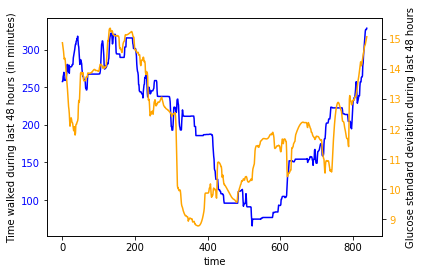

In [27]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(walking_time, color="blue")
ax1.set_xlabel("time")
ax1.set_ylabel("Time walked during last 48 hours (in minutes)")

ax2.plot(glucose_stddev, color="orange")
ax2.set_ylabel("Glucose standard deviation during last 48 hours")

def color_y_axis(ax, color):
    """Color your axes.
    
    Taken from : https://matplotlib.org/devdocs/gallery/api/two_scales.html
    """
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None
color_y_axis(ax1, "blue")
color_y_axis(ax2, "orange")

It appears that the two time series are linearly correlated. Therefore I will use Pearson's correlation coefficient and its p-value to test this hypothesis.

In [28]:
ss.pearsonr(walking_time, glucose_stddev)

(0.69277303385685052, 4.2400207667061358e-121)

The p-value is way below 5%, which means that the correlation is significant!

# Fourth task

## Prepare the data

In [29]:
indices = np.random.permutation(number_of_values)
train_indices = indices[:number_of_values // 2]
test_indices = indices[number_of_values // 2:]
X_train = np.expand_dims(walking_time[train_indices], 1)
X_test = np.expand_dims(walking_time[test_indices], 1)
Y_train = glucose_stddev[train_indices]
Y_test = glucose_stddev[test_indices]

Since the two time series are correlated, the first thing we should try is a linear regression. In order to avoid overfitting, I chose to use a Ridge penalty (instead of Lasso which is used when we want sparse coefficients, especially when we have a lot of input variables which is not the case here: we only have one).

In [30]:
regressor = linear_model.Ridge(alpha=1)

In [31]:
regressor.fit(X_train, Y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [32]:
regressor.coef_

array([ 0.01590545])

In [33]:
regressor.intercept_

8.9236636669847655

## Model evaluation

In [34]:
regressor.score(X_test, Y_test)

0.50795779862840185

The model does not accurately predict the blood glucose level standard deviation.